## Combining data- and task-driven approaches: use the representations learnt by the ResNet as input features to predict spikes
### Train a ConvNet on top of ResNet's 3rd layer

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=25b4233e-394c-4156-b9de-701281884665
To: /home/jupyter/Brain_like_mini_project/IT_data.h5
100%|██████████| 384M/384M [00:06<00:00, 59.0MB/s] 


'IT_data.h5'

#### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import pandas as pd
import torchvision.models as models

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Define the model

In [6]:
class Res_CNN(nn.Module):
    def __init__(self, features_in, features_out):
        super(Res_CNN, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=features_in, out_channels=512, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=512)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Linear layer 1
        self.fc1 = nn.Linear(in_features=256*2*2, out_features=512) 
        self.relu = nn.ReLU()
        
        # Linear layer 2
        self.fc2 = nn.Linear(in_features=512, out_features=features_out) 
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # conv 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # conv 2
    
        x = self.relu(self.fc1(x.view(x.size(0), -1))) # linear 1
        x = self.fc2(x)
        
        return x

#### Load the model

In [19]:
model = Res_CNN(features_in=1024, features_out=168) # 1024 is the number of features coming out from the ResNet's 3rd layer
model.load_state_dict(torch.load('res_cnn_layer3.pth', map_location=torch.device(device)))
model.to(device)

Res_CNN(
  (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=168, bias=True)
)

#### Evaluate the model's performance on the validation set

In [22]:
def resnet_layer3(stimulus, device):
    """Foward pass in the ResNet up to layer 3"""
    resnet = models.resnet50(pretrained=True)
    resnet = resnet.to(device)
    resnet.eval()
    x = stimulus
    for name, module in resnet.named_children():
        x = module(x)
        if name == 'layer3':
            spikes_repres = x
            break
    return spikes_repres

In [23]:
model.eval()
with torch.no_grad():
    stim = torch.Tensor(stimulus_val).to(device)
    spikes_pred = model(resnet_layer3(stim, device))
    pred = spikes_pred.cpu()

Mean EV: 0.30383089929819107


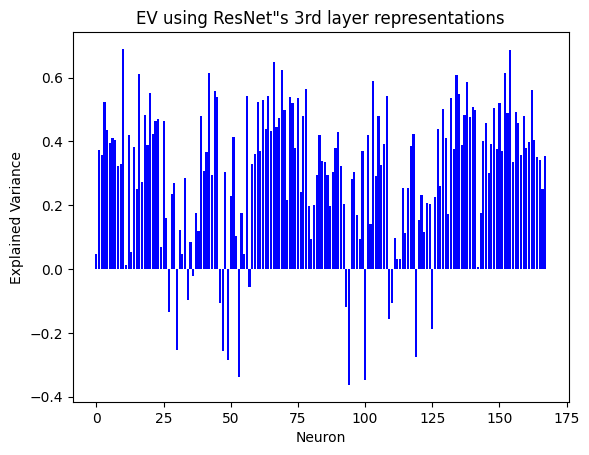

In [24]:
correlation_scores = []
explained_variance_scores = []

for i in range(spikes_val.shape[1]):
    # Correlation
    corr = np.corrcoef(spikes_val[:, i], pred[:, i])[0, 1]
    correlation_scores.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(spikes_val[:, i], pred[:, i])
    explained_variance_scores.append(explained_variance)

plt.bar(range(spikes_val.shape[1]), explained_variance_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Explained Variance')
plt.title('EV using ResNet"s 3rd layer representations')
print(f'Mean EV: {np.mean(explained_variance_scores)}')

Mean correlation: 0.5588865339243667


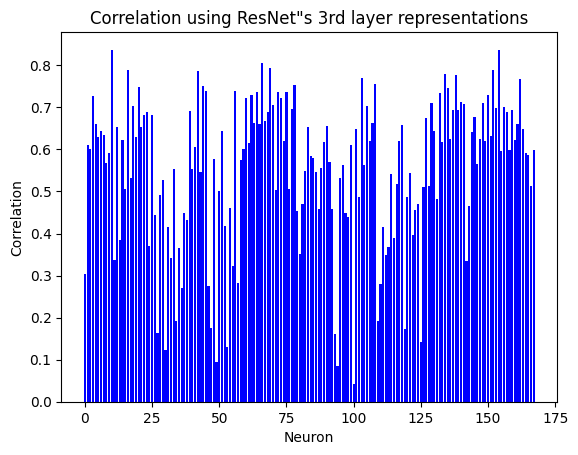

In [25]:
plt.bar(range(spikes_val.shape[1]), correlation_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Correlation')
plt.title('Correlation using ResNet"s 3rd layer representations')
print(f'Mean correlation: {np.mean(correlation_scores)}')